## Chain

### 1. Set Environment Variables

In [22]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

### 2. Set Messages and Model

Messages

In [23]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


Model

In [24]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [25]:
import sys
for chunk in llm.stream(messages):
    print(f"\033[1;31m{chunk.content}\033[0m",end="")
    sys.stdout.flush()

The best place to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. This area is renowned for its resident orca pods, specifically the Southern Resident killer whales, which are frequently spotted in the waters around the islands. 

The months between May and September are considered the best time for orca viewing, as the whales are often closer to shore and more active during these warmer months. There are numerous whale watching tours departing from towns like Friday Harbor on San Juan Island, as well as from Seattle and other nearby locations, providing excellent opportunities to observe these majestic creatures in their natural habitat.

Additionally, the coastline around the Olympic Peninsula and the waters of Puget Sound also offer good chances to see orcas, along with other marine wildlife.

### 3. Bind Tools and Test

In [26]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [27]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [28]:
print(f"tool_call.content: {tool_call.content}")
for key, value in tool_call.additional_kwargs['tool_calls'][0].items():
    print(f"{key}: {value}")

tool_call.content: 
id: call_j1U3SNrLwGeAUX6iWW6fdQAy
function: {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
type: function


### 4.MessagesState
- You can just use the MessagesState class from langgraph.graph.message.
- You can add any keys needed beyond messages, which is pre-built 

In [29]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [30]:
# initial messages
initial_messages = [
    AIMessage(content="Hello! How can I assist you?"),
    HumanMessage(content="I'm looking for information on marine biology.")
]

# add message
add_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?")

# total messages
from langgraph.graph.message import add_messages
messages = add_messages(initial_messages , add_message)
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you?
================================ Human Message =================================

I'm looking for information on marine biology.
================================== Ai Message ==================================

Sure, I can help with that. What specifically are you interested in?


### 5. Build Graph

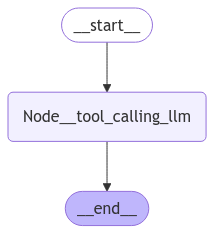

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def Node__tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

# set Node
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)

# set Edge
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_edge("Node__tool_calling_llm", END)

# compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### 6.Test

Not Call Tool
- if don't call tool
    - AIMessage have content.
    - AIMessage don't have additional_kwargs={'tool_calls'}

In [32]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='6218619e-3c27-40eb-9947-86e0a18c818b'),
  AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'stop', 'logprobs': None}, id='run-05bcacc8-cdea-4d92-9d82-924882088387-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

Call Tool
- if call tool
    - AIMessage don't have content.
    - AIMessage have additional_kwargs={'tool_calls'}

In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
messages

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1aa2ad29-0099-488b-b14c-d5f0e5f125c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3a8vgWmxEygJerq5k1ytz7Tw', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 58, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c95896eb-d477-4e5e-b2cd-da938c80531d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_3a8vgWmxEygJerq5k1ytz7Tw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 1

### 7. Router
- tools_condition is a function that returns True if the latest message (result) from assistant is a tool call, otherwise False.
    - latest message from assistant = `tool call` -> tools_condition routes to `tools`.
    - latest message from assistant = `not tool call` -> tools_condition routes to `END`.

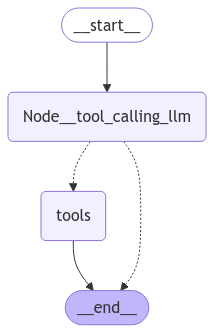

In [38]:
from langgraph.prebuilt import ToolNode

# Tools_condition
from langgraph.prebuilt import tools_condition

# Build graph
builder = StateGraph(MessagesState)

# set Node
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

# set Edge
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_conditional_edges("Node__tool_calling_llm",tools_condition)
builder.add_edge("tools", END) # Must set name of Node to tools

# compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### TestTool Router

In [39]:
from langchain_core.messages import HumanMessage
messages_not_call_tool = [HumanMessage(content="Hello world.")]
messages_not_call_tool = graph.invoke({"messages": messages_not_call_tool})
for m in messages_not_call_tool['messages']:
    m.pretty_print()

print("\n\n")

messages_call_tool = [HumanMessage(content="Multiply 2 and 3")]
messages_call_tool = graph.invoke({"messages": messages_call_tool})
for m in messages_call_tool['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?



================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_BM8T3Hn58OkpCIYNGTod0AFE)
 Call ID: call_BM8T3Hn58OkpCIYNGTod0AFE
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
